In [1]:
import os
import csv
import struct
import numpy as np
import math
from scipy.interpolate import interp1d, CubicSpline
import matplotlib.pyplot as plt
from typing import List, Tuple
from numpy.core import ndarray
from dataclasses import dataclass

In [2]:
@dataclass
class FeatureSingleEvent:
    """Feature of single event"""
    class_name: str
    peak: float 
    baseline: float 
    amplitude: float 
    d50: float 
    normalized_event: ndarray

def feature_single_event_as_list(f: FeatureSingleEvent):
    return [f.peak, f.baseline, f.amplitude, f.d50] + list(f.normalized_event) + [f.class_name]

In [3]:
@dataclass
class Feature:    
    """Feature of a measurement"""
    class_name: str
    avg_peak:float 
    max_peak:float
    avg_baseline:float
    avg_amplitudes:float 
    avg_d50:float
    stereotype: ndarray
    
def feature_as_list(f: Feature):
    return [f.avg_peak, f.max_peak, f.avg_baseline, f.avg_amplitudes, f.avg_d50, f.stereotype.size] + list(f.stereotype) + [f.class_name]

In [4]:
# forma d'onda normalizzata:
# in ampiezza dividendo per amplitude
# in durata facendo la spline su un numero fisso di campioni
def backup_normalize(event:ndarray, stereotype_length = 35) -> ndarray:
    ev_len = event.size
    normalizing_factor = abs(get_peak(event).min())
    x = [x for x in range(ev_len)]
    x_norm = np.linspace(0, ev_len-1, stereotype_length*3+4)
    f = interp1d(x, event/normalizing_factor)
    event_norm = f(x_norm)
    return event_norm[stereotype_length+3:2*stereotype_length+2]

In [5]:
show_plots = True
show_events_plots = True


event_stereotype_file_path = '/home/luca/py-scripts/event_stereotype_stored'
# event_stereotype_file_path =  os.path.join("C:\\","Users", "Luca Rossi", "Desktop","py-scripts", "event_stereotype_stored")

root_folder = r"/home/luca/Desktop/SARS-CoV"
# root_folder = os.path.join("C:\\","Users", "Luca Rossi", "Desktop", "extracted events")
event_folders = [root_folder + os.sep + d for d in os.listdir(root_folder)]

In [6]:
def open_dat(filename):
    f = open(filename, "rb")
    f_cont = f.read()
    f.close()
    raw = struct.unpack("d" * (len(f_cont) // 8), f_cont)
    return np.array(raw)

In [7]:
def plot(events: List[ndarray], name = None):
    fig, ax = plt.subplots()
    if name is not None:
        ax.set_title(name)
    for e in events:
        ax.plot(e)
    plt.show()

In [8]:
def different_plot(events: List[ndarray], name = None):
    for e in events:
        fig, ax = plt.subplots()
        if name is not None:
            ax.set_title(name)
        ax.plot(e)
    plt.show()

In [9]:
def plot_features(features: List[Tuple[float,float,float,float,ndarray]], name = None):
    fig, ax = plt.subplots()
    if name is not None:
        ax.set_title(name)
    for f in features:
        _, _, _, _, n = f
        ax.plot(n)
    plt.show()

In [10]:
def view_dat(filename):
    raw = open_dat(filename)
    plt.plot(raw)
    plt.show
# folder = "/home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_001"
# # view_dat()
# evs = extract_events(folder)
# plot(evs)

In [11]:
def get_peak(event: ndarray) -> ndarray:
    return event[event.size//5*2: event.size//5*3]

In [12]:
def extract_lengths(filename):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        events_lengths = []
        for row in csv_reader:
            if len(row) > 1:
                if line_count > 1:
                    events_lengths.append(int(row[1]) - int(row[0]))
            line_count+=1
        return events_lengths

In [13]:
def extract_events(dir_name) -> List[ndarray]:
    files = os.listdir(dir_name)
    dat_file = [dir_name + os.sep + f for f in files if f.endswith(".dat")].pop()
    details_file = [dir_name + os.sep + f for f in files if f.endswith(".csv")].pop()
    # caricamento eventi dal singolo file    
    loaded_events = open_dat(dat_file)
    # caricamento dettagli file
    events_length = extract_lengths(details_file)
    
    events = []
    b = 0
    for ev_len in events_length:
        e = b + ev_len
        event = np.array(loaded_events[b:e])
        b = e
        events.append(event)
    return events

In [14]:
def remove_short_events(events: List[ndarray]) -> List[ndarray]:
    return [e for e in events if e.size > 35]

In [15]:
def remove_noisy_events(events: List[ndarray]) -> List[ndarray]:
    return [e for e in events if abs(e.min()) - abs(e.max()) > 0.1 * abs(e.min())]

In [16]:
# durata dal momento in cui l'evento supera la percentuale x dell'escursione
# al momento in cui torna al di sotto della percentuale x dell'escursione
def duration_x(event: ndarray, baseline, amplitude, percentage):
    event_x = np.nonzero(event < baseline - amplitude * percentage )[0]
    # istante in cui l'evento supera la percentuale x dell'escursione
    begin_x = event_x[0]
    # istante in cui l'evento torna al di sotto della percentuale x dell'escursione
    end_x = event_x[-1]
    return end_x - begin_x

In [17]:
# calcolo la baseline sul primo 20% del primo quinto dei dati e
# sull'ultimo 20% dell'ultimo quinto dei dati
def calc_baseline(event: ndarray) -> float:
    ev_len = event.size
    x_baseline = np.concatenate((event[:round(ev_len/5*0.2)], event[round(ev_len - ev_len/5*0.2):]))
    return np.mean(x_baseline)

In [18]:
# forma d'onda normalizzata:
# in ampiezza dividendo per amplitude
# in durata facendo la spline su un numero fisso di campioni
def normalize(event:ndarray, stereotype_length = 35) -> ndarray:
    ev_len = event.size
    amplitude = abs(get_peak(event).min())
    x = np.array([x for x in range(ev_len)])
    x_norm = np.linspace(0, ev_len-1, stereotype_length*3+4)
    f = interp1d(x, event/amplitude, kind='cubic')
    event_norm = f(x_norm)
    return event_norm[stereotype_length+2:2*stereotype_length+2]

In [19]:
def extract_features_single_events(events_to_process: List[ndarray], class_name: str) -> List[FeatureSingleEvent]:
    features = []
    for event in events_to_process:
        peak = get_peak(event).min()
        baseline = calc_baseline(event)
        amplitude = baseline - peak
        d50 = duration_x(event, baseline, amplitude, 0.5)
        normalized_event = normalize(event)
        if normalized_event.max() < 0.2 and normalized_event.min() >= -1:
            features.append(FeatureSingleEvent(class_name, peak, baseline, amplitude, d50, normalized_event))
    return features

In [20]:
def normalize_list_of_features(list_of_features: ndarray):
    mean = np.mean(list_of_features)
    std_dev = np.std(list_of_features)
    return np.array([(f-mean) * std_dev for f in list_of_features])

In [21]:
# Usa solo le feature migliori e piu' robuste
def refine_features(features_to_process: List[FeatureSingleEvent]) -> Feature:
    if features_to_process is None or len(features_to_process) == 0:
        return None
    peaks = np.array([f.peak for f in features_to_process])
    baselines = np.array([f.baseline for f in features_to_process])
    amplitudes = np.array([f.amplitude for f in features_to_process])
    d50s = np.array([f.d50 for f in features_to_process])
    normalized_events = np.array([f.normalized_event for f in features_to_process])
    avg_peak = np.mean(peaks)
    max_peak = peaks.max()
    avg_baseline = np.mean(baselines)
    avg_amplitudes = np.mean(amplitudes)
    avg_d50 = np.mean(d50s)
    stereotype = np.sum(normalized_events, axis=0)/len(normalized_events)
    return Feature(features_to_process[0].class_name, avg_peak, max_peak,avg_baseline,avg_amplitudes, avg_d50, stereotype)

In [22]:
def debug_stuff(dir_name):
    print("extracting events from "+dir_name)
    events = extract_events(dir_name)
    print("events are " + str(len(events)))
    print("removing short events")
    events = remove_short_events(events)
    print("events are " + str(len(events)))
    print("removing noisy events")
    events = remove_noisy_events(events)
    print("events are " + str(len(events)))
    print("plotting events")
    plot(events, dir_name)
    print("extracting features")
    print("dir name",dir_name.split(os.sep).pop())
    features = extract_features_single_events(events, dir_name.split(os.sep).pop())
    print("plotting normalized events")
#     plot([f[-1] for f in features])
    feature = refine_features(features)
    plot([feature.stereotype])

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-4th_006
events are 23
removing short events
events are 23
removing noisy events
events are 23
plotting events


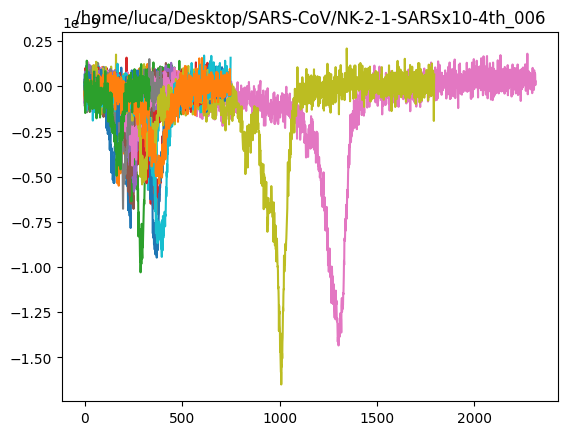

extracting features
dir name NK-2-1-SARSx10-4th_006
plotting normalized events


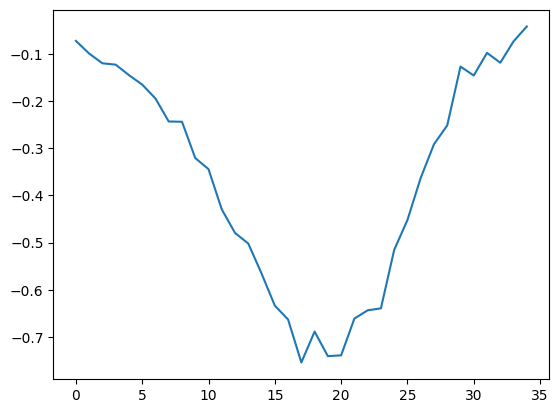

In [23]:
#testing stuff
first_measurement_dir = event_folders[0]
debug_stuff(first_measurement_dir)

In [24]:
# for measurement in event_folders:
#     debug_stuff(measurement)

In [25]:
def extract_features_from_events(dir_name, class_name) -> List[FeatureSingleEvent]:
    events = extract_events(dir_name)
    events = remove_short_events(events)
    events = remove_noisy_events(events)
    features = extract_features_single_events(events, class_name)
    return features

In [26]:
def extract(dir_name, class_name):
    features = extract_features_from_events(dir_name, class_name)
    return refine_features(features)    

In [27]:
def generate_header(feature_type: str = "Feature"):
    values = ["v"+str(i) for i in range(35)]
    if feature_type == "Feature":
        return ["avg_peak", "max_peak", "avg_baseline", "avg_amplitudes", "avg_d50", "number_of_events"] + values + ["class"]
    elif feature_type == "FeatureSingleEvent":
        return ["peak", "baseline", "amplitude", "d50"] + values + ["class"]
    
# print(generate_header())

In [28]:
def save_to_csv(path_to_file: str, header, rows):
    path_to_file = path_to_file + ".csv" if not path_to_file.endswith(".csv") else path_to_file
    with open(path_to_file, 'w', newline="") as f:
        # create the csv writer
        writer = csv.writer(f)
        # write a row to the csv file
        writer.writerow(header)
        writer.writerows(rows)

In [29]:
def analyze(root_folder, list_of_folders_to_analyze, func):
    infos = []
    for fta in list_of_folders_to_analyze:
        folder_to_analyze = root_folder + fta
        measurements_folders = [folder_to_analyze + os.sep + d for d in os.listdir(folder_to_analyze)]
        for mf in measurements_folders:
            res = func(mf, fta)
            if res is not None:
                #res is a list of feature_single_event, add the list to the one to return
                if isinstance(res, list):
                    infos += res
                # res is a single feature:
                else:
                    infos.append(res)
    return infos

In [30]:
# GENERAZIONE CSV DI FEATURE DA EVENTI SINGOLI PER MACHINE LEARNING
desktop_folder = r"/home/luca/Desktop/"
virus_folders = ["SARS-CoV", "SARS-CoV-2", "MERS-CoV", "HCoV-229E"]
infos = analyze(desktop_folder, virus_folders, extract_features_from_events)

header =  generate_header("FeatureSingleEvent")
rows = [feature_single_event_as_list(f) for f in infos]
save_to_csv("features_from_single_events",header, rows)

In [31]:
# GENERAZIONE CSV DI FEATURE PER MACHINE LEARNING
desktop_folder = r"/home/luca/Desktop/"
virus_folders = ["SARS-CoV", "SARS-CoV-2", "MERS-CoV", "HCoV-229E"]
infos = analyze(desktop_folder, virus_folders, extract)
header = generate_header("Feature")
rows = [feature_as_list(f) for f in infos]

save_to_csv("features",header, rows)

In [ ]:
# GENERAZIONE CSV TRAINING
desktop_folder = r"/home/luca/Desktop/training/"
virus_folders = ["positive", "negative"]
infos = analyze(desktop_folder, virus_folders, extract)
header = generate_header("Feature")
rows = [feature_as_list(f) for f in infos]

save_to_csv("training_data",header, rows)

In [ ]:
# feature = infos[0]
# print(feature.stereotype.size)
print(len(feature_as_list(feature)))
save_to_csv("features",header, rows)